# Fine-tuning BERT para Análisis de Sentimiento

# A - Introducción


Este notebook forma parte del Trabajo de Fin de Grado de Borja Dosuna Hernández titulado: **APLICACIÓN DE TÉCNICAS DE PLN AL ESTUDIO DEL COMPORTAMIENTO DE REDES SOCIALES DURANTE EVENTOS DEPORTIVOS** 

**Referencia**:

El procedimiento seguido en este notebook viene inspirado por el siguiente artículo: https://skimai.com/fine-tuning-bert-for-sentiment-analysis/



# B - Preparación

## 1. Cargar librerías esenciales

In [1]:
#import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

%matplotlib inline

## 2. Dataset

### 2.1. Load Train Data

In [4]:
with open('FIFA_2014_sentiment_dataset_processed.json') as json_file:
    data = json.load(json_file)

column1 = []
column2 = []
column3 = []

for item in data.items():
  column1.append(item[0])
  column2.append(item[1][0])
  column3.append(item[1][1])

data = pd.DataFrame(list(zip(column1, column3,column2)),
               columns =['id', 'text', 'category'])

# Display 5 random samples
data.sample(5)

,id,text,category
10494,477181413582966784,Who's Watching #WorldCup,positive
202,477160271924850689,The opening ceremony was a big disappointment....,negative
12076,477020355576729600,I'm quite excited #WorldCup2014 ⚽⚽⚽,positive
9000,480861620785004544,Ugh. That last goal was the worst. #WorldCup2014,negative
7248,477177090677030912,LETS GOOO! WOOOP WOOP! #WorldCup2014 #WorldCup...,positive


Se eliminan los tuits anotados como neutrales

In [5]:
data = data[data['category'] != 'neutral']

In [6]:
data

,id,text,category
1,477584843283259392,"After today's superb performance, Robin was of...",positive
2,478036760815878144,@rdhinds This is what we need after those bori...,positive
3,478021085330673664,"#bih vs #arg tomorrow.... yisss, I AM EXCITE! ...",positive
4,477537690028900354,Holy shit what a goal! #RVP #WorldCup #TheHol...,positive
7,478309890117865472,@FinallyMario sumpper mario! Sweet heading♥,positive
...,...,...,...
22667,477863879352287232,"@England Let's show the same spirit, adventure...",positive
22668,478230073540378624,The great thing about this World Cup so far is...,positive
22669,477537202902421504,Persie!!! Splendid... That was awesome! #World...,positive
22671,477533158582546432,"@DFergPR doesn't agree, but I think Xabi Alons...",positive


In [7]:
drop_indices = np.random.choice(data.index, 7670, replace=False)
data_subset = data.drop(drop_indices)
data_subset

,id,text,category
1,477584843283259392,"After today's superb performance, Robin was of...",positive
2,478036760815878144,@rdhinds This is what we need after those bori...,positive
4,477537690028900354,Holy shit what a goal! #RVP #WorldCup #TheHol...,positive
8,477015863275446272,@Cristiano hai ronaldo \n\ni hope you win the ...,positive
15,478990851847495680,@D_Sturridge nice italy match sturridge,positive
...,...,...,...
22660,478928401810874368,I'm so excited for part 2 on Saturday! Nigeria...,negative
22664,478356962237616128,@jasondavidson29 @fourdiegos @chr1s_cahill @Ky...,positive
22669,477537202902421504,Persie!!! Splendid... That was awesome! #World...,positive
22671,477533158582546432,"@DFergPR doesn't agree, but I think Xabi Alons...",positive


In [8]:
split_indices = np.random.choice(data_subset.index, 1000, replace=False)
data_train_val = data_subset.drop(split_indices)
data_test = data_subset.loc[split_indices]

In [9]:
data_train_val

,id,text,category
1,477584843283259392,"After today's superb performance, Robin was of...",positive
2,478036760815878144,@rdhinds This is what we need after those bori...,positive
4,477537690028900354,Holy shit what a goal! #RVP #WorldCup #TheHol...,positive
8,477015863275446272,@Cristiano hai ronaldo \n\ni hope you win the ...,positive
15,478990851847495680,@D_Sturridge nice italy match sturridge,positive
...,...,...,...
22658,476700052334055425,&gt; Scifo all but destroyed England at Italia...,positive
22660,478928401810874368,I'm so excited for part 2 on Saturday! Nigeria...,negative
22669,477537202902421504,Persie!!! Splendid... That was awesome! #World...,positive
22671,477533158582546432,"@DFergPR doesn't agree, but I think Xabi Alons...",positive


In [10]:
data_test

,id,text,category
13755,477837542994497536,"""Quick, we have to hurry home to see the. #gre...",positive
12719,477459302991794176,@neymarjr #NeymarBoraDancarOneDirectionNaCopa ...,positive
21374,477486471998238720,Mexican coach blows up after player kicks Came...,negative
16781,480045752149082113,@FinallyMario Your fucking shit,negative
1901,477200162620977152,Brazil have won 8 of their last 9 #WorldCup ga...,positive
...,...,...,...
15088,477178611473350657,WORLD CUP!!!!!!!!!!!! #WorldCup #WorldCup2014,positive
3021,477550387801911296,So SO pleased for Holland. If England can't/do...,positive
10343,477177096343523328,And they're out of the tunnel! #Brazil2014 #Wo...,positive
14497,477479257715646464,"@AndrewWK Partying, Watching #WorldCup2014 #Me...",positive


In [11]:
label_dict = {
    'positive' : 1,
    'negative' : 0
}

data_train_val['label'] = data_train_val.category.replace(label_dict)

data_train_val.sample(5)

,id,text,category,label
10964,477212412978806784,It has begun! #worldcup #lolagaspar #brazil ht...,positive,1
17899,478226883667300352,"68' still a goal apiece, an entertaining game...",positive,1
10733,476759224417275904,Tomorrow! #WorldCup2014,positive,1
14159,477832739174244352,"World Cup, like all of modernity, is built upo...",negative,0
20315,480861136175128577,Why you mad USA???? #WorldCup,negative,0


In [12]:
label_dict = {
    'positive' : 1,
    'negative' : 0
}

data_test['label'] = data_test.category.replace(label_dict)

data_test.sample(5)

,id,text,category,label
19035,477184064974098432,Wooowww What A Start..\nAll Set For A Classic ...,positive,1
13597,478684564546928641,I was just starting to doze off there. That's ...,positive,1
1218,477554556780699648,FT #Spain got murked. #Holland win 5 - 1. Shoc...,positive,1
21481,479729568803471360,I will be 41 for the next #WorldCup. Totally u...,negative,0
6604,476401770730897409,2 more days!!! #WorldCup2014,positive,1


Se separa aleatoriamente el total del conjunto de datos anotados entre: un conjunto de entrenamienton con el 90% de los datos y un conjunto de prueba con el 10% restante

In [13]:
from sklearn.model_selection import train_test_split

X = data_train_val.text.values
y = data_train_val.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.1, random_state=2020)

## 3. Set up GPU for training

Google Colab offers free GPUs and TPUs. Since we'll be training a large neural network it's best to utilize these features.

Google Colab ofrece GPUs y TPUs gratuitas. Como el entrenamiento de una red neuronal es un proceso costoso el proyecto se beneficia de estas características.

Una GPU puede añadirse de la siguiente manera:

`Entorno de ejecución -> Cambiar tipo de entorno de ejecución -> Acelerador por hardware: GPU`


In [14]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

The transformer library of Hugging Face contains PyTorch implementation of state-of-the-art NLP models including BERT (from Google), GPT (from OpenAI) ... and pre-trained model weights.

In [16]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 30.0 MB/s 
     |████████████████████████████████| 596 kB 61.5 MB/s 
     |████████████████████████████████| 6.6 MB 39.1 MB/s 
     |████████████████████████████████| 101 kB 10.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## 2. Tokenization and Input Formatting

Antes de tokenizar el texto, se realiza un ligero procesado.

In [17]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [18]:
# Print sentence 0
print('Original: ', X[0])
print('Processed: ', text_preprocessing(X[0]))

Original:  After today's superb performance, Robin was officially invited to become a member of the Justice League
#WorldCup2014 http://t.co/GwrD9SrVPn
Processed:  After today's superb performance, Robin was officially invited to become a member of the Justice League #WorldCup2014 http://t.co/GwrD9SrVPn


### 2.1. BERT Tokenizer

Para utiliar el modelo BERT preentrenado, se debe utilizar el tokenizer provisto por la librería. Debido a que (1) el modelo tiene un vocabulario específico y (2) el tokenizer de BERT tiene una manera particular de manejar las palabras que no se encuentran en su vocabulario.

Además, es necesario realizar una serie adicional de cambios.





In [19]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            truncation=True,
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
data = data_train_val
test_data = data_test

Antes de tokenizar es necesario definir la longitud máxima de las frases.

In [21]:
# Concatenate train data and test data
all_tweets = np.concatenate([data.text.values, test_data.text.values])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  71


In [22]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Original:  After today's superb performance, Robin was officially invited to become a member of the Justice League
#WorldCup2014 http://t.co/GwrD9SrVPn
Token IDs:  [101, 2044, 2651, 1005, 1055, 21688, 2836, 1010, 5863, 2001, 3985, 4778, 2000, 2468, 1037, 2266, 1997, 1996, 3425, 2223, 1001, 2088, 15569, 11387, 16932, 8299, 1024, 1013, 1013, 1056, 1012, 2522, 1013, 1043, 13088, 2094, 2683, 21338, 2615, 2361, 2078, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


### 2.2. Crear un DataLoader con Pytorch



We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

Se crea un iterador para nuestro conjunto de datos utilizando la clase DataLoader de Torch. Esto ahorrará memoria durante el entrenamiento y mejorará la velocidad.

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 3. Train Our Model

### 3.1. Create BertClassifier



Se crea una clase BertClassifier con el modelo BERT para eliminar la última capa escondida y un red neuronal feed-forward con una capa escondida que sirve como clasificador.

In [23]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 26.3 ms, sys: 964 µs, total: 27.3 ms
Wall time: 29.4 ms


### 3.2. Optimizador y Planeador de velocidad de aprendizajes





In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Bucle de entrenamiento

In [25]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [28]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=2)
train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.661406   |     -      |     -     |   7.98   
   1    |   40    |   0.506471   |     -      |     -     |   7.50   
   1    |   60    |   0.426112   |     -      |     -     |   7.62   
   1    |   80    |   0.403726   |     -      |     -     |   7.71   
   1    |   100   |   0.388488   |     -      |     -     |   7.84   
   1    |   120   |   0.413022   |     -      |     -     |   7.94   
   1    |   140   |   0.443811   |     -      |     -     |   7.89   
   1    |   160   |   0.396991   |     -      |     -     |   7.80   
   1    |   180   |   0.370404   |     -      |     -     |   7.75   
   1    |   200   |   0.391339   |     -      |     -     |   7.70   
   1    |   220   |   0.389167   |     -      |     -     |   7.64   
   1    |   240   |   0.381651   |     -      |     -     |   7.64   


### 3.4. Evaluación sobre el conjunto de validación

In [29]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [44]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.figure(dpi=1200)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('roc-auc.png',dpi=1200)
    plt.show()

AUC: 0.9355
Accuracy: 86.11%


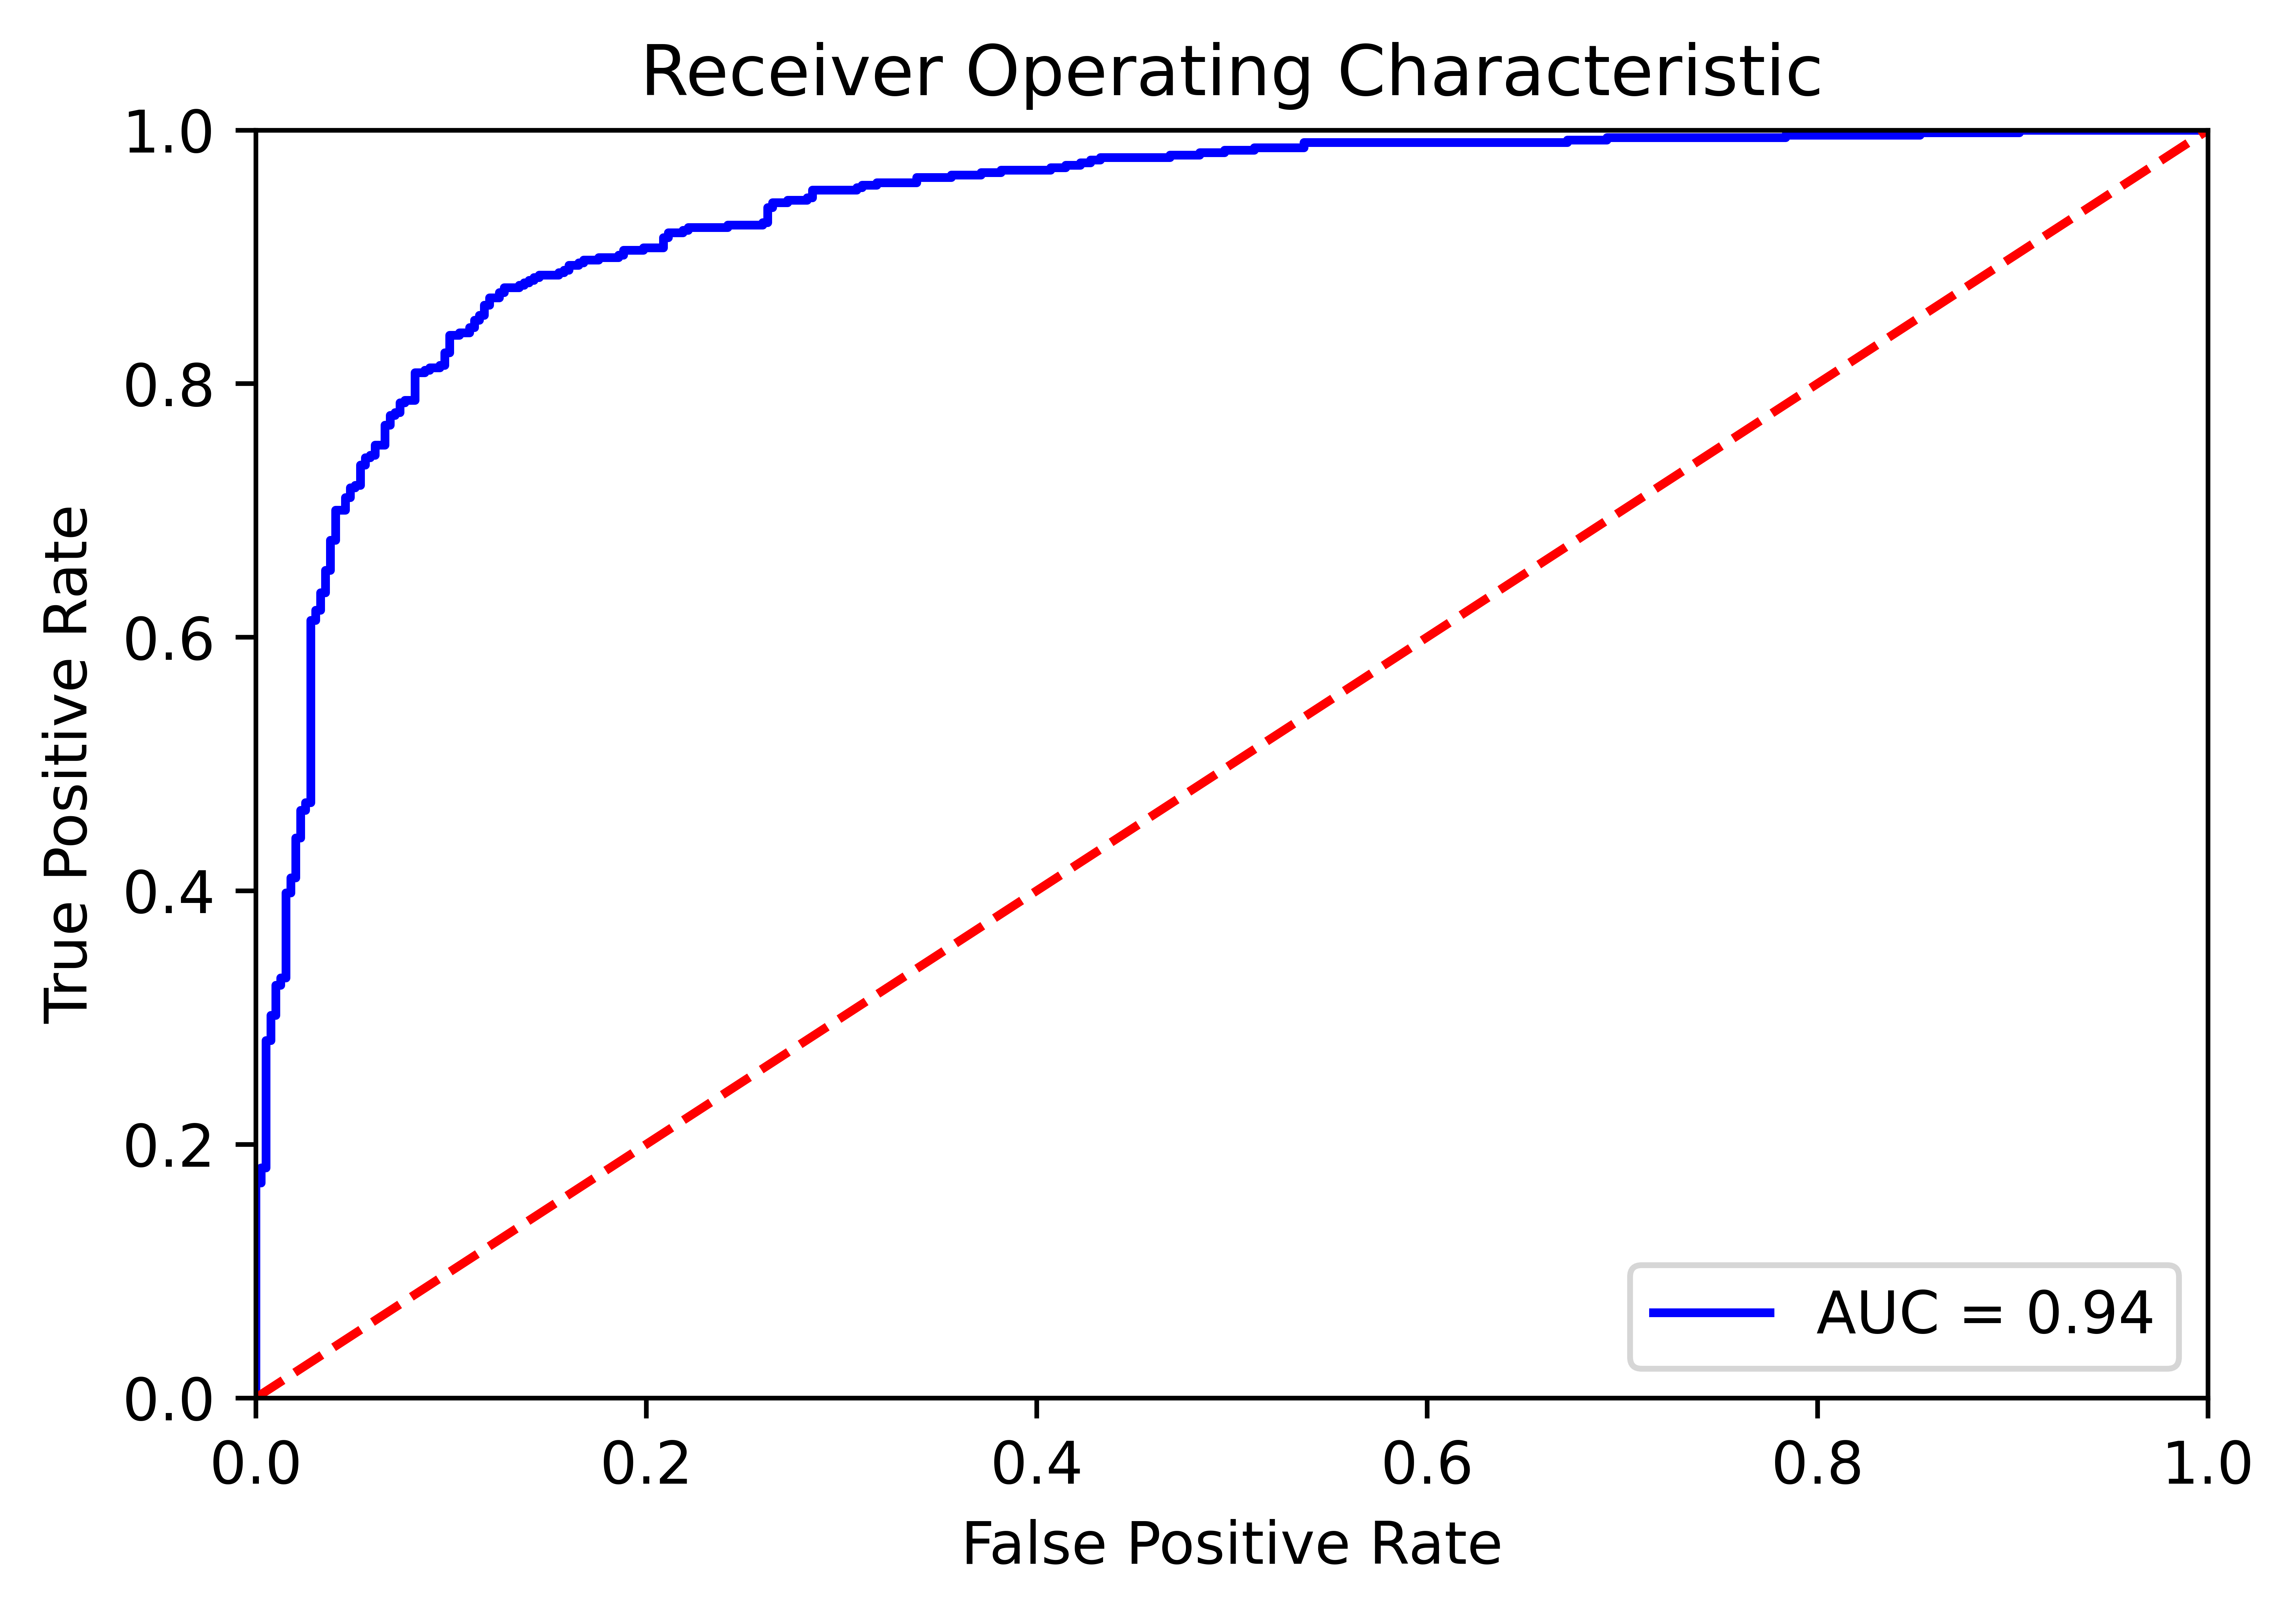

In [30]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

El clasificador de BERT consigue 0.9355 de puntuación AUC y un 86.11% de precisión.

## 4. Prediciones sobre el conjunto de Prueba

### 4.1. Preparación de los datos

In [31]:
test_data.category.value_counts()

positive    575
negative    425
Name: category, dtype: int64

In [32]:
test_data = test_data.drop(columns=['category', 'label'])

In [33]:
test_data.sample(5)

,id,text
13057,478661663739359232,@ussoccer the sport might not get the attentio...
12606,477025208096653312,"""@liyaJ81: Wonder who will have the better #Wo..."
13865,479700377957183488,@england better keep an eye on @luis16suarez. ...
21634,478797189884706817,What is the relevant of #WorldCup2014 to #Chib...
20313,477844863828783104,Hell yeah.....And the weekend has officially s...


In [34]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


### 4.2. Predicciones

In [35]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

In [36]:
# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds.sum())

Number of tweets predicted non-negative:  586


Se examina una muestra de 10 tweets anotados comom positivo.

In [37]:
output = test_data[preds==1]
list(output.sample(10).text)

['Great to see an African legend like Jay-jay Okocha in the #Supersport team \n#SSFootball #WorldCup2014Countdown  #WorldCup2014',
 'I want to install an Ian Darke at my place so he can tell me rich soccer stories of old before I go to bed at night. #WorldCup',
 'Wow, what a header by the guy with the nice hair. #Analysis #WorldCup',
 'Brazil looking extremely sluggish to start this game, and Croatia most definitely came to play. #WorldCup\xa0',
 'See All The #WorldCup Action ! #FIFAWorldCupBrazil .. The First 4 Match, http://t.co/DoQTTDMeV7',
 'hehe #Brasil2014 for #WorldCup2014 no other juss them #WorldCup',
 '#WorldCup #WorldCup2014 @CollectorClubGB @antiquemark COME ON ENGLAND!! http://t.co/2PAfjivkBm',
 '"@lendehkemokai: Lol another Goal mad by #Brazil yet again!....... Brazil 3-1 Croatia.   Goodby Croatia. #WorldCup"',
 "Our Man of the Match award goes to Brazil's Oscar. Worked hard all game and rewarded with a goal at the end. #WorldCup #BRAvsCRO",
 'Mehicoooooo! Well deserved g

# E - Predicciones sobre el conjunto de tweets extraído

En esta sección se realizan las predicciones sobre los tweets publicados durante el partido del Manchester City - Liverpool del día 10/04/2018.

In [38]:
df = pd.read_json("CITY-LIVERPOOL-2018-VUELTA-en.json", orient = "records")
df

,Date,Text,Username,Player
0,2018-04-10 20:44:39,@ManeKampf Fuck ederson the fucking cunt thug,Jagisinho,Ederson
1,2018-04-10 20:44:16,@LFC Can needs to stay so we have an enforcer....,fezz816,Ederson
2,2018-04-10 20:43:51,@thebijaar @Jompa_02 @gdaygallagher @booneboxt...,JackTer11093393,Ederson
3,2018-04-10 20:43:23,A big fuck you to Ederson.,firmihoe,Ederson
4,2018-04-10 20:43:21,"I always love you Selecao Brasilera, i am sorr...",LimbargoVenn,Ederson
...,...,...,...,...
54420,2018-04-10 19:16:37,Ings &amp; Solanke will take us to Kiev https:...,Umair_ua,Ings
54421,2018-04-10 18:59:57,Liverpool will beat Man City (QF)\n\nLiverpool...,FPLHints,Ings
54422,2018-04-10 18:55:22,@Ben__SCFC @Ben_Rowley56 I’d rather get beat b...,olly_hodgey94,Ings
54423,2018-04-10 18:53:20,"SUPLENTES 🇬🇧⚽️| Mignolet, Clyne, Moreno, Klava...",Contexto21,Ings


In [39]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(df.Text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [40]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, test_dataloader)

In [41]:
# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Total number of tweets: ", len(preds))
print("Number of tweets predicted non-negative: ", preds.sum())

Total number of tweets:  54425
Number of tweets predicted non-negative:  27475


In [42]:
df.insert(3, "predictions", preds, True)
df

,Date,Text,Username,predictions,Player
0,2018-04-10 20:44:39,@ManeKampf Fuck ederson the fucking cunt thug,Jagisinho,0,Ederson
1,2018-04-10 20:44:16,@LFC Can needs to stay so we have an enforcer....,fezz816,0,Ederson
2,2018-04-10 20:43:51,@thebijaar @Jompa_02 @gdaygallagher @booneboxt...,JackTer11093393,0,Ederson
3,2018-04-10 20:43:23,A big fuck you to Ederson.,firmihoe,0,Ederson
4,2018-04-10 20:43:21,"I always love you Selecao Brasilera, i am sorr...",LimbargoVenn,1,Ederson
...,...,...,...,...,...
54420,2018-04-10 19:16:37,Ings &amp; Solanke will take us to Kiev https:...,Umair_ua,1,Ings
54421,2018-04-10 18:59:57,Liverpool will beat Man City (QF)\n\nLiverpool...,FPLHints,1,Ings
54422,2018-04-10 18:55:22,@Ben__SCFC @Ben_Rowley56 I’d rather get beat b...,olly_hodgey94,0,Ings
54423,2018-04-10 18:53:20,"SUPLENTES 🇬🇧⚽️| Mignolet, Clyne, Moreno, Klava...",Contexto21,1,Ings


In [43]:
with open('CITY-LIVERPOOL-2018-VUELTA-en-predictions.json', 'w', encoding='utf-8') as file:
    df.to_json(file, orient = 'records',force_ascii=False)